# Analyse data

## Preconditions

### Precondition 1
Need to import libraries **only once** each time jupiter notebook is launched

In [1]:
import numpy
import pandas
import re
import spacy
import xlsxwriter

from collections import Counter
from ipyfilechooser import FileChooser
from matplotlib import pyplot
from matplotlib.axes import Axes
from pathlib import Path
from pandas import DataFrame
from pandas.core.series import Series
from spacy.tokens import Doc
from typing import List

# Download spacy NLP model
spacy_model = 'en_core_web_sm'
try:
    nlp = spacy.load(spacy_model)
except OSError:
    print('Downloading language model for the spaCy POS tagger\n'
        "(don't worry, this will only happen once)")
    from spacy.cli import download
    download(spacy_model)
    nlp = spacy.load(spacy_model)

### Precondition 2
Define methods that will be used further in this notebook. Need to run this section **only once** each time jupiter notebook is launched. Also need to do it each time you update the code

In [2]:
def remove_illegal_chars(text: str) -> str:
    """
    Remove all characters from the given text that are not English letters, 
    numbers, and " " (space character).
    return updated text
    """
    text = re.sub('[^A-Za-z0-9\ ]+', '', text)
    text.strip()
    return text


def _replace_na_with_zeros(series: Series) -> Series:
    na_values = ['Na', 'None', 'None ', 'na', 'N/A', ' ']
    return series[~series.isin(na_values)]


def plot_bar_chart(series: Series, ax: Axes = None) -> None:
    """
    Show a bar chart for given data series.
    Values such as NaN, None, etc. are converted to 0.
    Data values are lazy sorted
    Data values are converted to percentages.
    x labels are rotated 15%
    """
    if series.empty:
        print("No Data for bar chart")
    else:
        _replace_na_with_zeros(series) \
            .fillna('0') \
            .replace(['Na', 'None', 'None ', 'na'], '0') \
            .sort_values() \
            .value_counts(normalize=True) \
            .mul(100).round(1).plot(
                ylabel="percentage",
                kind="bar",
                rot=15,
                ax=ax,
        )


def plot_1_10_hist_chart(series: Series) -> None:
    """
    Print mean value and show histogram chart for given data series.
    Always show x axis 1 to 10
    """
    print(f'Mean value is {round(series.mean(), 1)}')

    series.plot(
        kind='hist',
        xticks=range(1, 11)
    )


def filter_out_nan(series: Series) -> Series:
    """
    Return new series without NaN values, without updating data frame
    """
    nan_values = series.isnull()
    return series[~nan_values]


def merge_into_single_string(series: Series) -> str:
    """Self evident"""
    return ' '.join(series.values.tolist())


def _filter_out_keywords(doc: Doc) -> List:
    drop_words = [' ', '0', 'who', 'impacts', 'na']

    return [
        token.text.lower()
        for token in doc
        if not token.is_stop
        and (token.pos_ == "NOUN" or token.pos_ == "PROPN" or token.pos_ == "PRON")
        and not token.is_punct
        and not token.text.lower() in drop_words
    ]


def get_nouns_from(series: Series) -> List:
    """
    Return list of nouns for given data series. Replace known synonyms.
    """
    text_to_analyse = remove_illegal_chars(merge_into_single_string(series))
    nlp_doc = nlp(text_to_analyse)

    nouns = _filter_out_keywords(nlp_doc)

    # Replace known synonyms
    synonyms = [('budget', 'cost'),
                ('covid', 'pandemic')]
    for (syn1, syn2) in synonyms:
        nouns = [word.replace(syn1, syn2) for word in nouns]

    return nouns


def plot_most_common_words(words: List[str], top: int, ax: Axes = None) -> None:
    """
    Shows empty chart if "Other" option was not chosen
    """
    if len(words) > 0:
        # Get top words
        nouns_freq = Counter(words)
        top_nouns = nouns_freq.most_common(top)
        print(f'All keywords:\n{nouns_freq}')

        display_counter = Counter()
        for (k, v) in top_nouns:
            display_counter[k] = v

        # Create a plot
        # Credit to https://stackoverflow.com/a/22222738/8661297
        keys = display_counter.keys()
        y_pos = numpy.arange(len(keys))
        x_values = display_counter.values()
        max_value = display_counter.most_common(1)[0][1]

        if ax:
            ax.barh(y_pos, x_values)
        else:
            pyplot.barh(y_pos, x_values)

        pyplot.yticks(y_pos, keys)
        pyplot.xticks(range(0, (max_value+1)))


def plot_text_answer(series: Series, top: int, ax: Axes = None) -> None:
    nouns = get_nouns_from(_replace_na_with_zeros(filter_out_nan(series)))
    plot_most_common_words(words=nouns, top=top, ax=ax)


def plot_multichoice_with_other(series: Series, expected_values: List, top: int) -> None:
    """
    Show 2 plots if enough data
    First plot is plot_bar_chart() for expected values
    Second plot is plot_text_answer() for "Other" values
    """
    temp_s = series.str.split(';').apply(pandas.Series).stack()
    temp_s.index = temp_s.index.droplevel(-1)

    expected_series = temp_s[temp_s.isin(expected_values)]
    unexpected_series = temp_s[~temp_s.isin(expected_values)]
    
    width = 6.5
    height = 12
    between = 0.4

    fig, axs = pyplot.subplots(2, figsize=(width, height))
    pyplot.subplots_adjust(hspace=between)

    plot_bar_chart(expected_series, ax=axs[0])
    plot_text_answer(unexpected_series, top=top, ax=axs[1])


### Precondition 3
Choose raw excel file. 
Download survey results to your computer. Select downloaded file with "Select" button. 
The button will appear once you run the code below

In [3]:
raw_data = FileChooser()
display(raw_data)

FileChooser(path='/Users/obondarev/work/github/neu-capstone/notebooks', filename='', title='', show_hidden=Fal…

## Read the file
### Step 1
Read the file, remove unparsible characters, and print available columns

In [4]:
# open excel file as pandas dataframe
raw_df = pandas.read_excel(io=raw_data.selected, 
                            sheet_name='Form1')

# remove illegal characters from column names
headers_list = raw_df.columns.values.tolist()
headers_list = list(map(remove_illegal_chars, headers_list))
raw_df.columns = headers_list

# Print result
print(f'All columns after cleanup:')
print(*headers_list, sep = "\n")


All columns after cleanup:
ID
Start time
Completion time
Email
Name
Have you hired Big Sky Franchise Team
How likely would you recommend Big Sky Franchise Team to a friend or colleague 1 is not at all likely and 10 is extremelylikely
What year did you start franchising
Did you complete the franchise process
What do you think are Big Skys Franchise Team strengths
What do you think are Big Skys Franchise Team weaknesses
How would you rate your overall experience while working with Big Sky on a scale of 110 1 worst  10 best
Do you have a franchise or plan to start oneSelect all that apply
How many locations do you currently have
What were the reasons to close the franchise Select all that apply
What areas do you need help with Select all that apply
Would you like to participate in an optional interview to share more insights
Please share your email so that we may contact you for an optional interview Leave empty if you prefer to be anonymous
Business Name Leave empty if you prefer to be a

### Step 2
Choose columns that you will be working with by listing them below. Use single quotes and seperate by comas.

In [5]:
necessary_columns = [
    'Have you hired Big Sky Franchise Team',
    'How likely would you recommend Big Sky Franchise Team to a friend or colleague 1 is not at all likely and 10 is extremelylikely',
    'If you were to do it all over would you hire Big Sky again',
    'If no could you please tell why',
    'What year did you start franchising',
    'How many total franchises have you sold since you started franchisingif not applicable enter NA',
    'How many franchises did you sell in your first yearif not applicable enter NA',
    'How many franchises did you sell in your second year if not applicable enter NA',
    'How many franchises did you sell in your third yearif not applicable enter NA',
    'What were your biggest challenges or obstacles to launching your franchise program',
    'What were your biggest challenges to selling franchises',
    'What have been your biggest challenges in supporting your franchisees select all that apply2',
    'What areas do you need help with Select all that apply',
    'Would you like to participate in an optional interview to share more insights',
    'Please share your email so that we may contact you for an optional interview Leave empty if you prefer to be anonymous',
    'Business Name Leave empty if you prefer to be anonymous',
    ]


### Step 3
Filter columns based on the list above

In [6]:
df = raw_df.filter(items=necessary_columns, axis=1)

## Parse questions

### 1. Have you hired Big Sky Franchise Team?

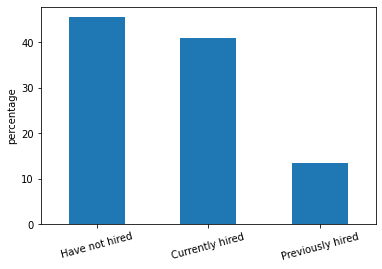

In [7]:
plot_bar_chart(df['Have you hired Big Sky Franchise Team'])

### 2. How likely would you recommend Big Sky Franchise Team to a friend or colleague? 

Mean value is 9.2


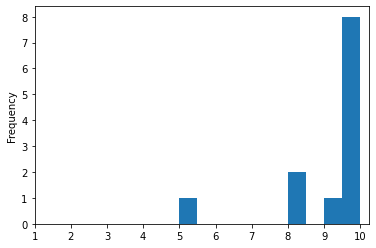

In [8]:
column_name = 'How likely would you recommend Big Sky Franchise Team to a friend or colleague 1 is not at all likely and 10 is extremelylikely'
plot_1_10_hist_chart(df[column_name])


### 3. If you were to do it all over, would you hire Big Sky again?

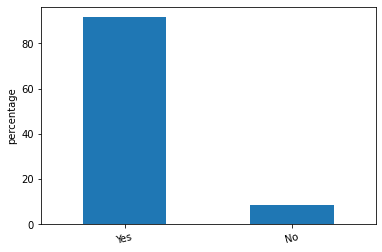

In [9]:
# Drop NaN values. Are they coming from non customers? Need to add a better filter... TBD!
column_name = 'If you were to do it all over would you hire Big Sky again'
plot_bar_chart(filter_out_nan(df[column_name]))

### 4. If no, could you please tell why?

In [ ]:
# No values so far. skipping

### 5. What year did you start franchising?

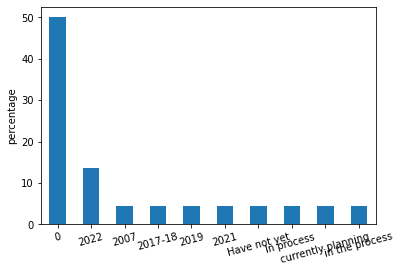

In [10]:
plot_bar_chart(df['What year did you start franchising'])

### 6/7/8/9. How many total franchises have you sold ...

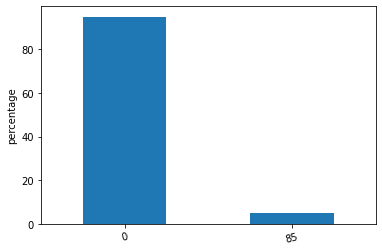

In [12]:
column_name = 'How many total franchises have you sold since you started franchisingif not applicable enter NA'
plot_bar_chart(df[column_name])

### 10. What were your biggest challenges or obstacles to launching your franchise program?

All keywords:
Counter({'cost': 2, 'pandemic': 2, 'franchise': 1, 'consultant': 1, 'documents': 1, 'person': 1, 'house': 1, 'brand': 1, 'fdd': 1, 'marketing': 1, 'set': 1, 'process': 1, 'buyer': 1, 'numbers': 1, 'franchises': 1, 'workload': 1, 'program': 1})


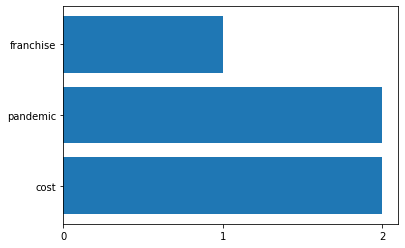

In [15]:
column_name = 'What were your biggest challenges or obstacles to launching your franchise program'
plot_text_answer(df[column_name], top=3)

### 11. What were your biggest challenges to selling franchises?

In [ ]:
column_name = 'What were your biggest challenges to selling franchises'
plot_text_answer(df[column_name], top=3)

### 12. What have been your biggest challenges in supporting your franchisees

All keywords:
Counter({'franchisees': 1, 'answer': 1})


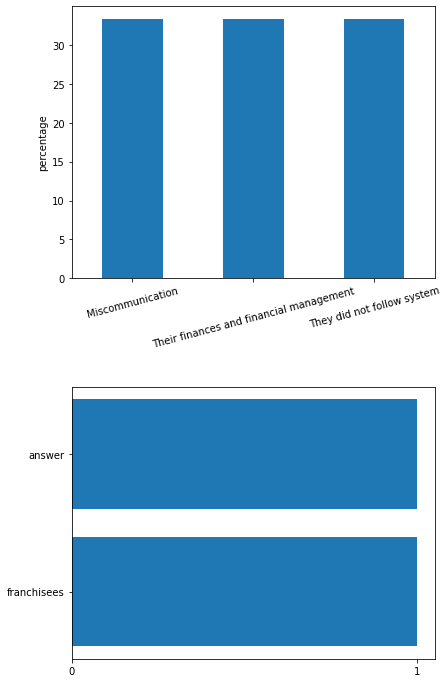

In [11]:
column_name = 'What have been your biggest challenges in supporting your franchisees select all that apply2'
expected_values = [
	'None', 'Their motivation', 'They did not follow system', 'Their finances and financial management', 
	'Lack of marketing spend by franchisee', 'Quality issues', 
	'My (or franchisor) coaching skills', 'Miscommunication'
]
plot_multichoice_with_other(series=df[column_name], expected_values=expected_values, top=5)

### 13. What areas do you need help with?

In [ ]:
column_name = 'What areas do you need help with Select all that apply'
expected_values = [
	'None', 'Whole franchising process', 'Business plan', 'Financial processes', 
	'Competitors analysis', 'Legal documentation', 'Licensing documentation', 
	'Marketing', 'Quality Assurance', 'Franchisee training processes', 'Technical support'
]
plot_multichoice_with_other(series=df[column_name], expected_values=expected_values, top=2)

### 14/15/16. Private data, count number of volunteers only

## Save to files.... do we need this? :thinking_face: TBD!

In [ ]:
clients_df = df[df['Have you hired Big Sky Franchise Team?'] != 'Have not hired']

Select necessary excel columns for clients' responses. Use single quotes and seperate by comas.

In [ ]:
cl_columns = [
    'How likely would you recommend Big Sky Franchise Team to a friend or colleague? 1 is not at all likely and 10 is extremelylikely',
    'If you were to do it all over would you hire Big Sky again?',
    'If no could you please tell why?',
    'What year did you start franchising?',
    'How many franchises did you sell in your second year? if not applicable enter NA2'
    'How many franchises did you sell in your first year?if not applicable enter NA',
    'How many franchises did you sell in your second year? if not applicable enter NA',
    'How many franchises did you sell in your third year?if not applicable enter NA',
    'What were your biggest challenges or obstacles to launching your franchise program?',
    'What were your biggest challenges to selling franchises?',
    'What have been your biggest challenges in supporting your franchisees select all that apply?2',
    'Would you like to participate in an optional interview to share more insights?',
    'Please share your email so that we may contact you for an optional interview Leave empty if you prefer to be anonymous',
    'Business Name Leave empty if you prefer to be anonymous',
    ]


In [ ]:
clients_df = clients_df.filter(items=cl_columns, axis=1)

## Group nonclients in a separate dataframe

In [ ]:
nonclients_df = df[df['Have you hired Big Sky Franchise Team?'] == 'Have not hired']

Select necessary excel columns for nonclients' responses. Use single quotes and seperate by comas.

In [ ]:
non_cl_columns = [
    'What areas do you need help with? Select all that apply',
    'Please share your email so that we may contact you for an optional interview Leave empty if you prefer to be anonymous',
    'Business Name Leave empty if you prefer to be anonymous',
    ]


In [ ]:
nonclients_df = nonclients_df.filter(items=non_cl_columns, axis=1)

Save results (choose folder and output filename without '.xlsx' extension)

In [ ]:
target = FileChooser()
display(target)

In [ ]:
target_path = target.selected + '.xlsx'
writer = pandas.ExcelWriter(target_path, engine='xlsxwriter')

clients_df.to_excel(excel_writer=writer, sheet_name='Clients')
nonclients_df.to_excel(excel_writer=writer, sheet_name='NonClients')

writer.save()

Thats all!